/tmp/ipykernel_59880/3259164102.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab20", len(communities))


Граф сохранён в: /home/jovyan/work/reports/client_graph.png


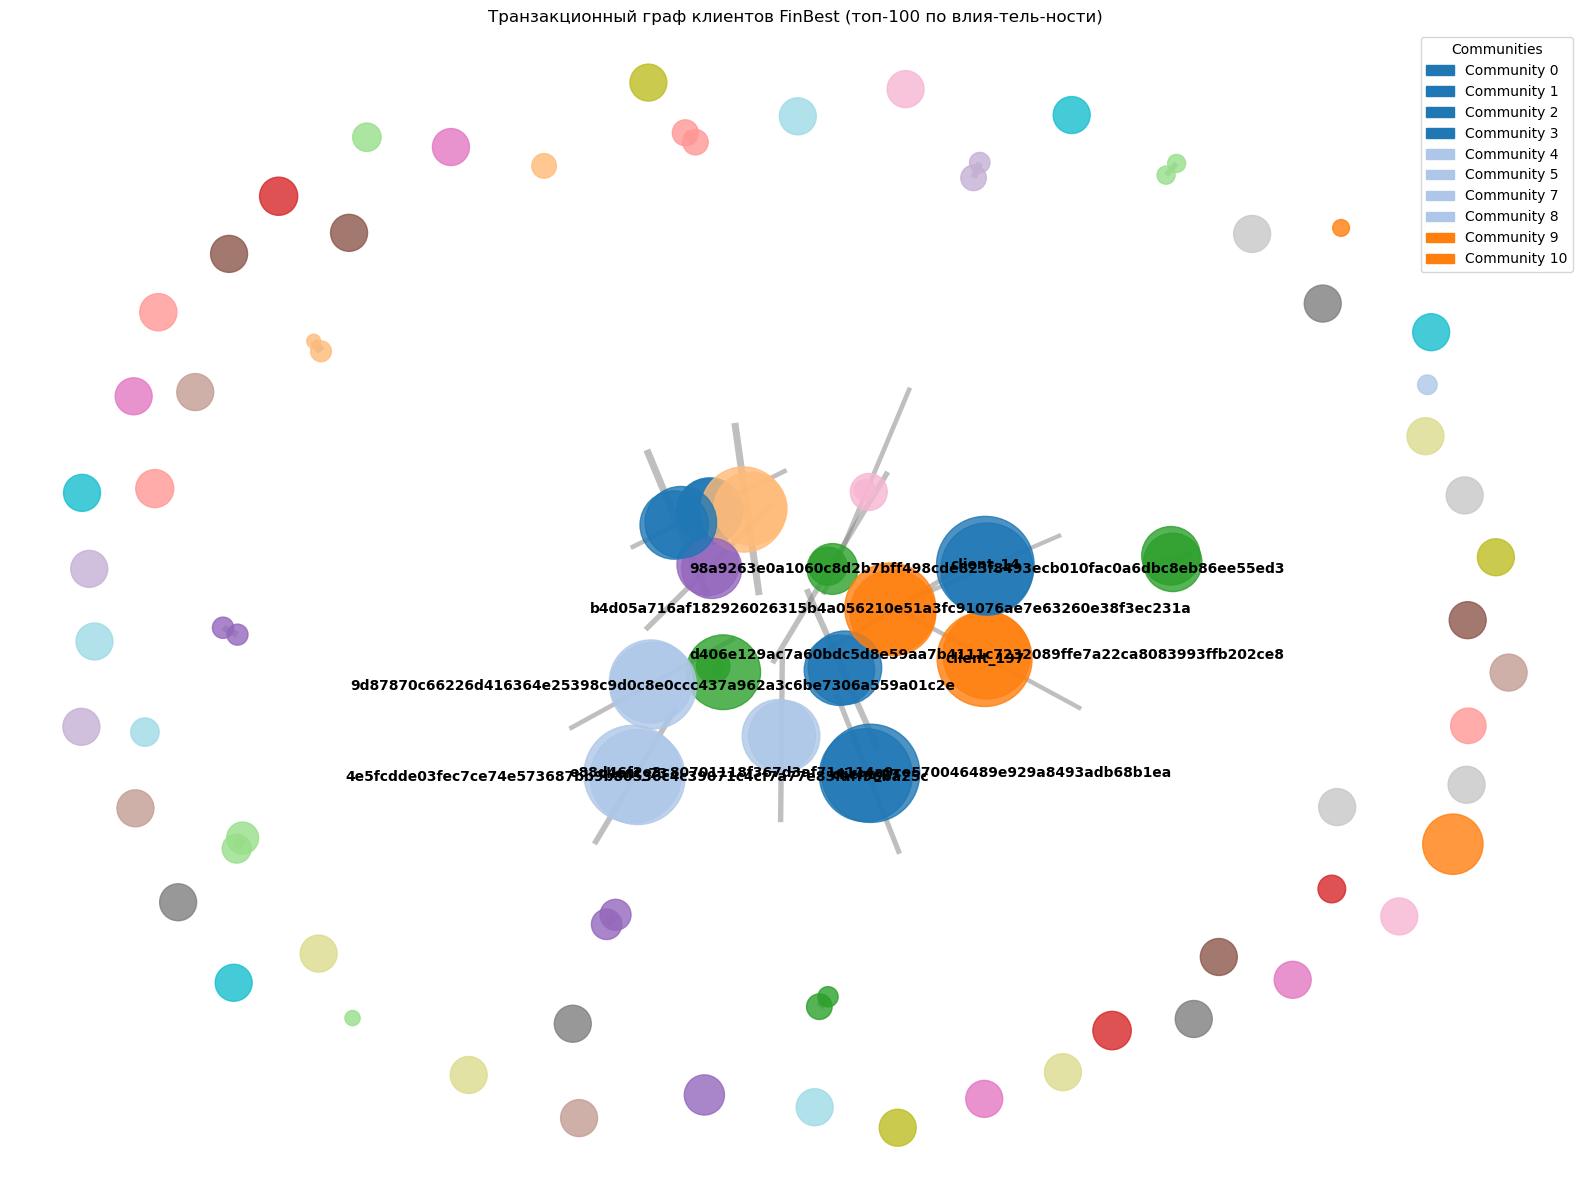

In [17]:
# -*- coding: utf-8 -*-
"""
client_graph_plot.py — «транзакционный» граф в стилистике примера
"""

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from networkx.algorithms.community import greedy_modularity_communities

GRAPH_PATH   = "/home/jovyan/work/reports/client_graph.graphml"
OUT_PNG      = "/home/jovyan/work/reports/client_graph.png"
TOP_N        = 100      # сколько узлов оставить
LABEL_N      = 10       # сколько подписать
EDGE_ALPHA   = 0.5      # прозрачность рёбер
NODE_MIN     = 100      # px
NODE_MAX     = 5000     # px

# --------------------------------------------------------------------------- #
# 1) читаем граф и «человечим» имена атрибутов
# --------------------------------------------------------------------------- #
G = nx.read_graphml(GRAPH_PATH)

id2name = {"d0": "community", "d1": "influence",
           "d2": "community_size", "d3": "w_degree"}

for n, attrs in G.nodes(data=True):
    clean = {k.split("}")[-1]: v for k, v in attrs.items()}  # убираем namespace
    for raw, nice in id2name.items():
        if raw in clean and nice not in clean:
            clean[nice] = clean.pop(raw)
    G.nodes[n].clear()
    G.nodes[n].update(clean)

# --------------------------------------------------------------------------- #
# 2) если вдруг нет community / influence  →  вычислим
# --------------------------------------------------------------------------- #
if any("community" not in d for d in G.nodes.values()):
    comms = greedy_modularity_communities(G, weight="weight")
    nx.set_node_attributes(G,
        {v: i for i, c in enumerate(comms) for v in c}, "community")

if any("influence" not in d for d in G.nodes.values()):
    nx.set_node_attributes(G, nx.pagerank(G, weight="weight"), "influence")

# приводим типы
for d in G.nodes.values():
    d["community"] = int(float(d["community"]))
    d["influence"] = float(d["influence"])

# --------------------------------------------------------------------------- #
# 3) оставляем TOP-N по влиятельности (чтобы не было «синего шара»)
# --------------------------------------------------------------------------- #
top_nodes = sorted(G.nodes,
                   key=lambda n: G.nodes[n]["influence"],
                   reverse=True)[:TOP_N]
G = G.subgraph(top_nodes).copy()

# --------------------------------------------------------------------------- #
# 4) вычисляем layout (force-directed)
# --------------------------------------------------------------------------- #
pos = nx.spring_layout(G, k=0.15, iterations=50, seed=42, weight="weight")

# --------------------------------------------------------------------------- #
# 5) цвета / размеры
# --------------------------------------------------------------------------- #
communities = sorted(set(nx.get_node_attributes(G, "community").values()))
cmap = cm.get_cmap("tab20", len(communities))
comm_color = {c: cmap(i) for i, c in enumerate(communities)}

node_sizes = [
    NODE_MIN + (G.nodes[n]["influence"] - min(nx.get_node_attributes(G, "influence").values()))
    / (max(nx.get_node_attributes(G, "influence").values())
       - min(nx.get_node_attributes(G, "influence").values()) + 1e-9)
    * (NODE_MAX - NODE_MIN)
    for n in G
]
node_colors = [comm_color[G.nodes[n]["community"]] for n in G]

# --------------------------------------------------------------------------- #
# 6) сам рисунок
# --------------------------------------------------------------------------- #
plt.figure(figsize=(16, 12))

# узлы
nx.draw_networkx_nodes(G, pos,
                       node_size=node_sizes,
                       node_color=node_colors,
                       alpha=0.8)

# рёбра
edge_weights = [G[u][v].get("weight", 1.0) for u, v in G.edges()]
nx.draw_networkx_edges(G, pos,
                       width=[w * 0.5 for w in edge_weights],
                       alpha=EDGE_ALPHA,
                       edge_color="grey")

# подписи (TOP-LABEL_N)
top_labels = sorted(G.nodes,
                    key=lambda n: G.nodes[n]["influence"],
                    reverse=True)[:LABEL_N]
nx.draw_networkx_labels(G, pos,
                        labels={n: n for n in top_labels},
                        font_size=10, font_weight="bold")

# легенда
legend_patches = [
    mpatches.Patch(color=comm_color[c], label=f"Community {c}")
    for c in communities[:10]                 # >10 сообществ — каша; показываем первые
]
plt.legend(handles=legend_patches, title="Communities",
           loc="upper right", frameon=True)

plt.title(f"Транзакционный граф клиентов FinBest (топ-{TOP_N} по влия­тель­ности)")
plt.axis("off")
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=300, bbox_inches="tight")
print(f"Граф сохранён в: {OUT_PNG}")


/tmp/ipykernel_59880/3008156151.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap("tab20")


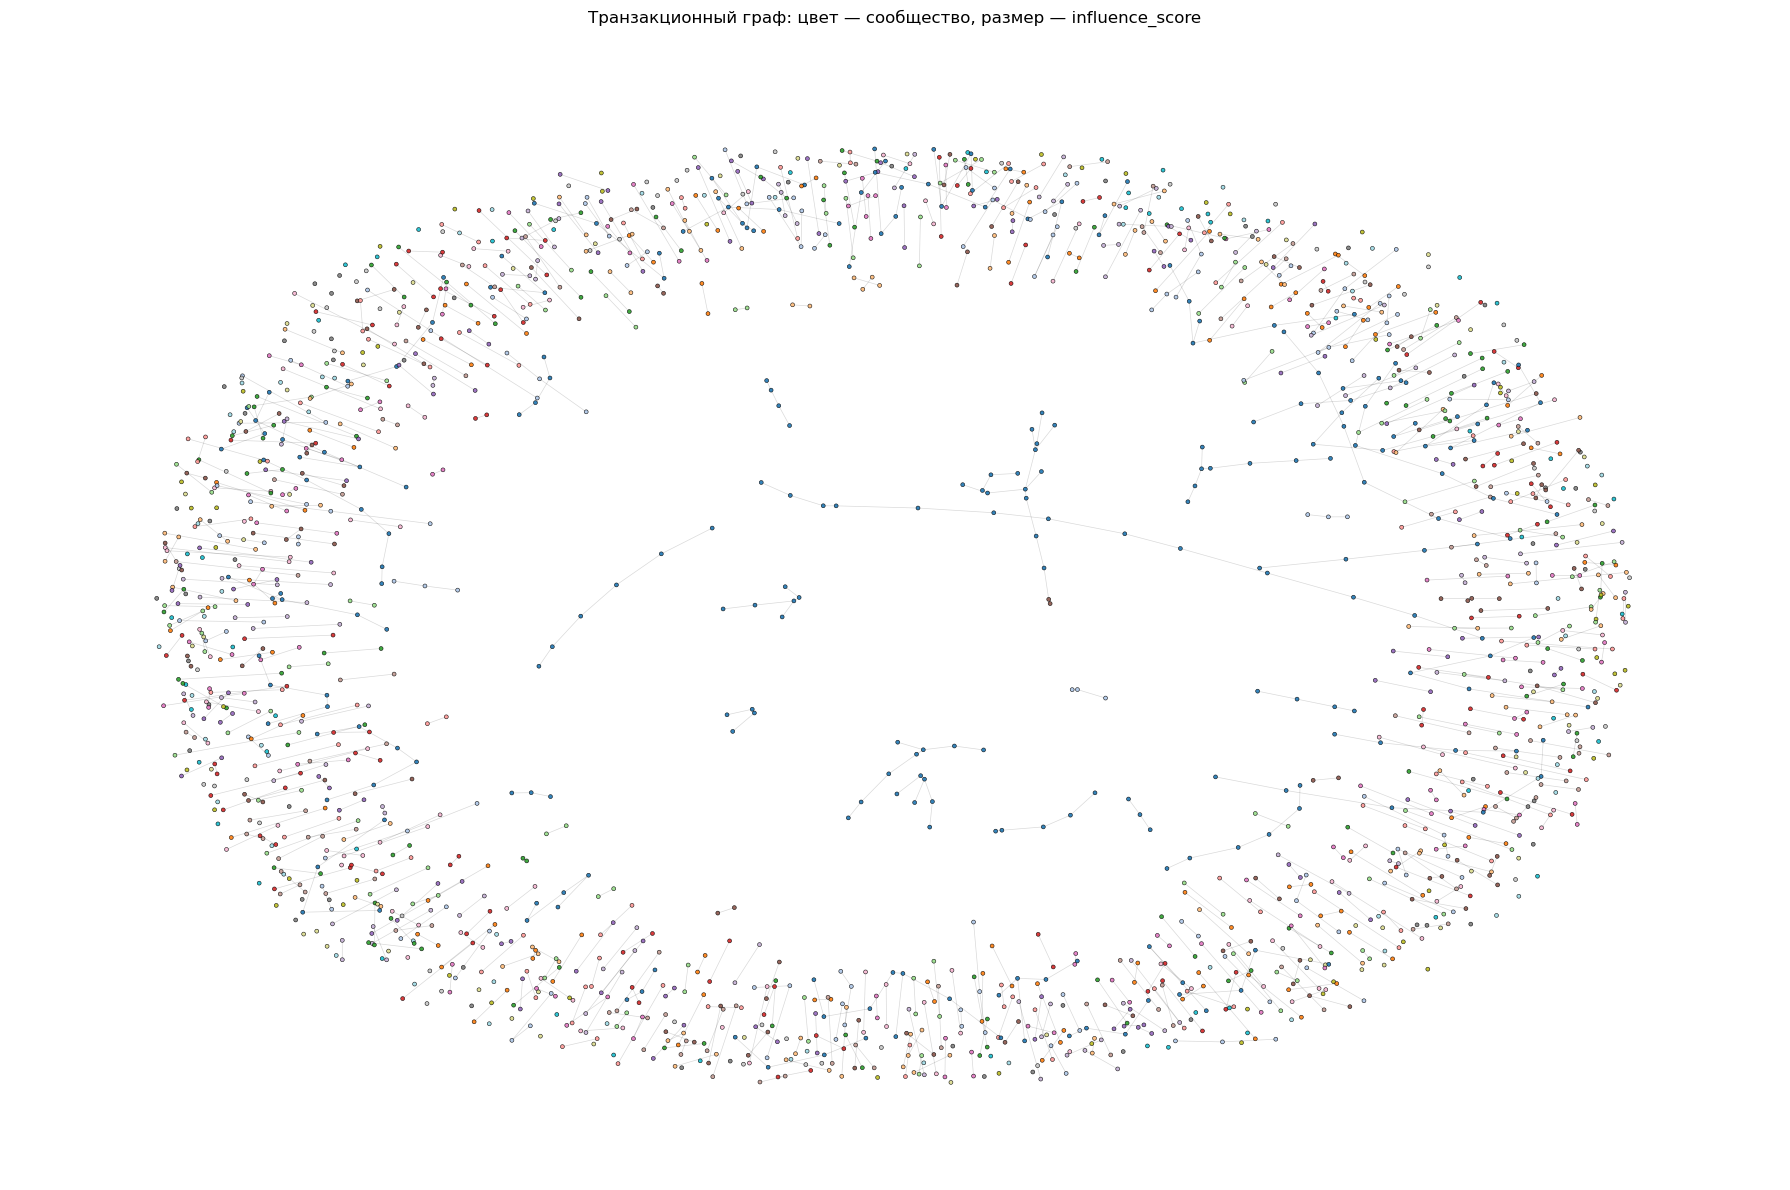

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from networkx.algorithms.community import greedy_modularity_communities

PATH = "/home/jovyan/work/reports/client_graph.graphml"
G = nx.read_graphml(PATH)

# ---------- 1. Полная нормализация имён -------------------------------------
id2name = {"d0": "community_id",
           "d1": "influence_score",
           "d2": "community_size",
           "d3": "w_degree"}

for n, attr in G.nodes(data=True):
    # cнимем XML-namespace, если есть
    clean = {k.split("}")[-1]: v for k, v in attr.items()}
    # d0…d3 → читаемые имена
    for raw, nice in id2name.items():
        if raw in clean and nice not in clean:
            clean[nice] = clean.pop(raw)
    G.nodes[n].clear()
    G.nodes[n].update(clean)

# ---------- 2. Добавим недостающие атрибуты ---------------------------------
need_comm   = [n for n, d in G.nodes(data=True) if "community_id"    not in d]
need_pager  = [n for n, d in G.nodes(data=True) if "influence_score" not in d]

if need_comm:
    comms = greedy_modularity_communities(G, weight="weight")
    nx.set_node_attributes(G, {v: i for i, c in enumerate(comms) for v in c},
                           "community_id")

if need_pager:
    pr = nx.pagerank(G, weight="weight")
    nx.set_node_attributes(G, pr, "influence_score")

# ---------- 3. Безопасное приведение типов ----------------------------------
for d in G.nodes.values():
    d["community_id"]    = int(float(d["community_id"]))
    d["influence_score"] = float(d["influence_score"])

# ---------- 4. Визуализация --------------------------------------------------
pos = nx.spring_layout(G, k=0.15, seed=42, weight="weight")

comm = [d["community_id"] for d in G.nodes.values()]
uniq = sorted(set(comm))
palette = cm.get_cmap("tab20")
colors = [palette(uniq.index(c) / max(len(uniq)-1, 1)) for c in comm]

sizes = [max(d["influence_score"], 0.01) * 800 for d in G.nodes.values()]

plt.figure(figsize=(18, 12))
nx.draw_networkx_edges(G, pos, alpha=0.15, width=0.5)
nx.draw_networkx_nodes(G, pos,
                       node_color=colors,
                       node_size=sizes,
                       edgecolors="black",
                       linewidths=0.4,
                       alpha=0.9)
plt.title("Транзакционный граф: цвет — сообщество, размер — influence_score",
          pad=20)
plt.axis("off")
plt.tight_layout()
plt.show()


/tmp/ipykernel_59880/453436690.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap("tab20")


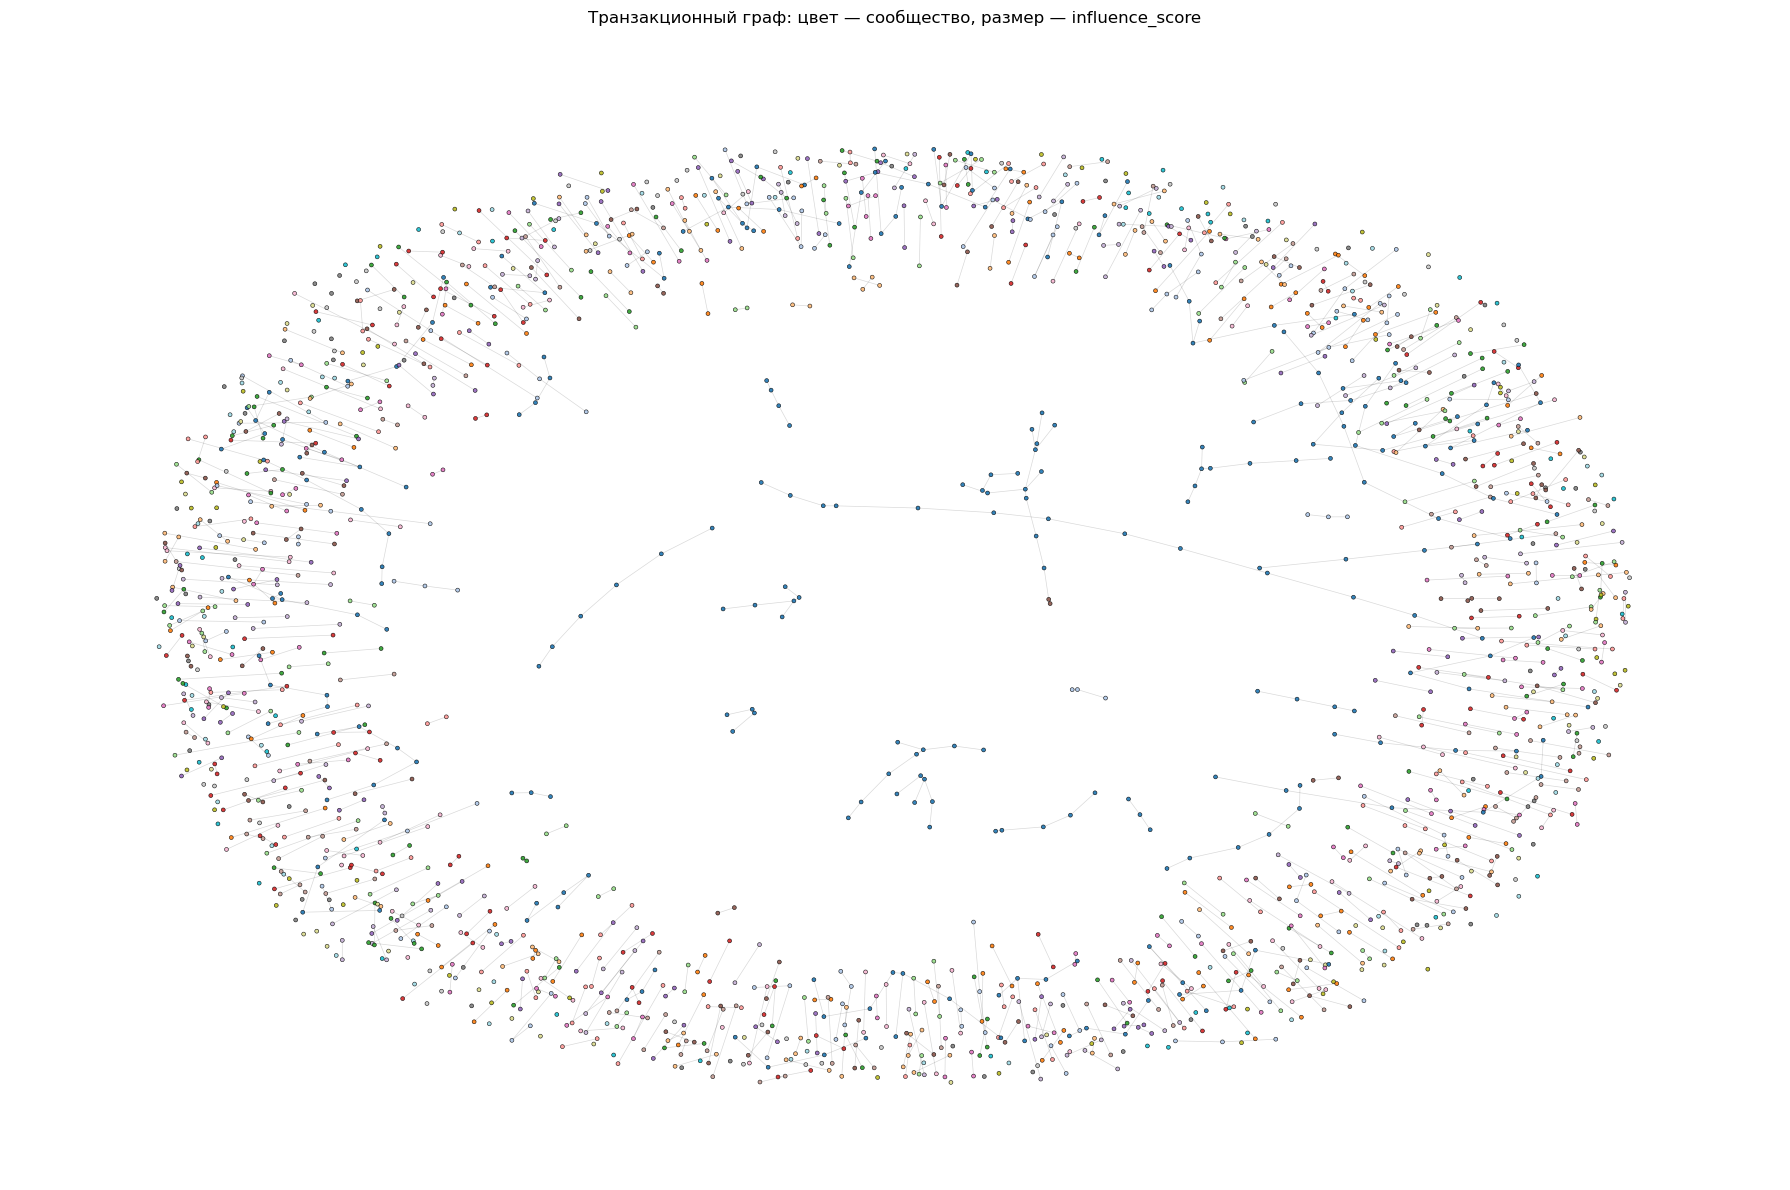

In [ ]:

for n, attr in G.nodes(data=True):
    # cнимем XML-namespace, если есть
    clean = {k.split("}")[-1]: v for k, v in attr.items()}
    # d0…d3 → читаемые имена
    for raw, nice in id2name.items():
        if raw in clean and nice not in clean:
            clean[nice] = clean.pop(raw)
    G.nodes[n].clear()
    G.nodes[n].update(clean)

# ---------- 2. Добавим недостающие атрибуты ---------------------------------
need_comm   = [n for n, d in G.nodes(data=True) if "community_id"    not in d]
need_pager  = [n for n, d in G.nodes(data=True) if "influence_score" not in d]

if need_comm:
    comms = greedy_modularity_communities(G, weight="weight")
    nx.set_node_attributes(G, {v: i for i, c in enumerate(comms) for v in c},
                           "community_id")

if need_pager:
    pr = nx.pagerank(G, weight="weight")
    nx.set_node_attributes(G, pr, "influence_score")

# ---------- 3. Безопасное приведение типов ----------------------------------
for d in G.nodes.values():
    d["community_id"]    = int(float(d["community_id"]))
    d["influence_score"] = float(d["influence_score"])

# ---------- 4. Визуализация --------------------------------------------------
pos = nx.spring_layout(G, k=0.15, seed=42, weight="weight")

comm = [d["community_id"] for d in G.nodes.values()]
uniq = sorted(set(comm))
palette = cm.get_cmap("tab20")
colors = [palette(uniq.index(c) / max(len(uniq)-1, 1)) for c in comm]

sizes = [max(d["influence_score"], 0.01) * 800 for d in G.nodes.values()]

plt.figure(figsize=(18, 12))
nx.draw_networkx_edges(G, pos, alpha=0.15, width=0.5)
nx.draw_networkx_nodes(G, pos,
                       node_color=colors,
                       node_size=sizes,
                       edgecolors="black",
                       linewidths=0.4,
                       alpha=0.9)
plt.title("Транзакционный граф: цвет — сообщество, размер — influence_score",
          pad=20)
plt.axis("off")
plt.tight_layout()
plt.show()


/tmp/ipykernel_59880/2541133894.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap      = cm.get_cmap("tab20")


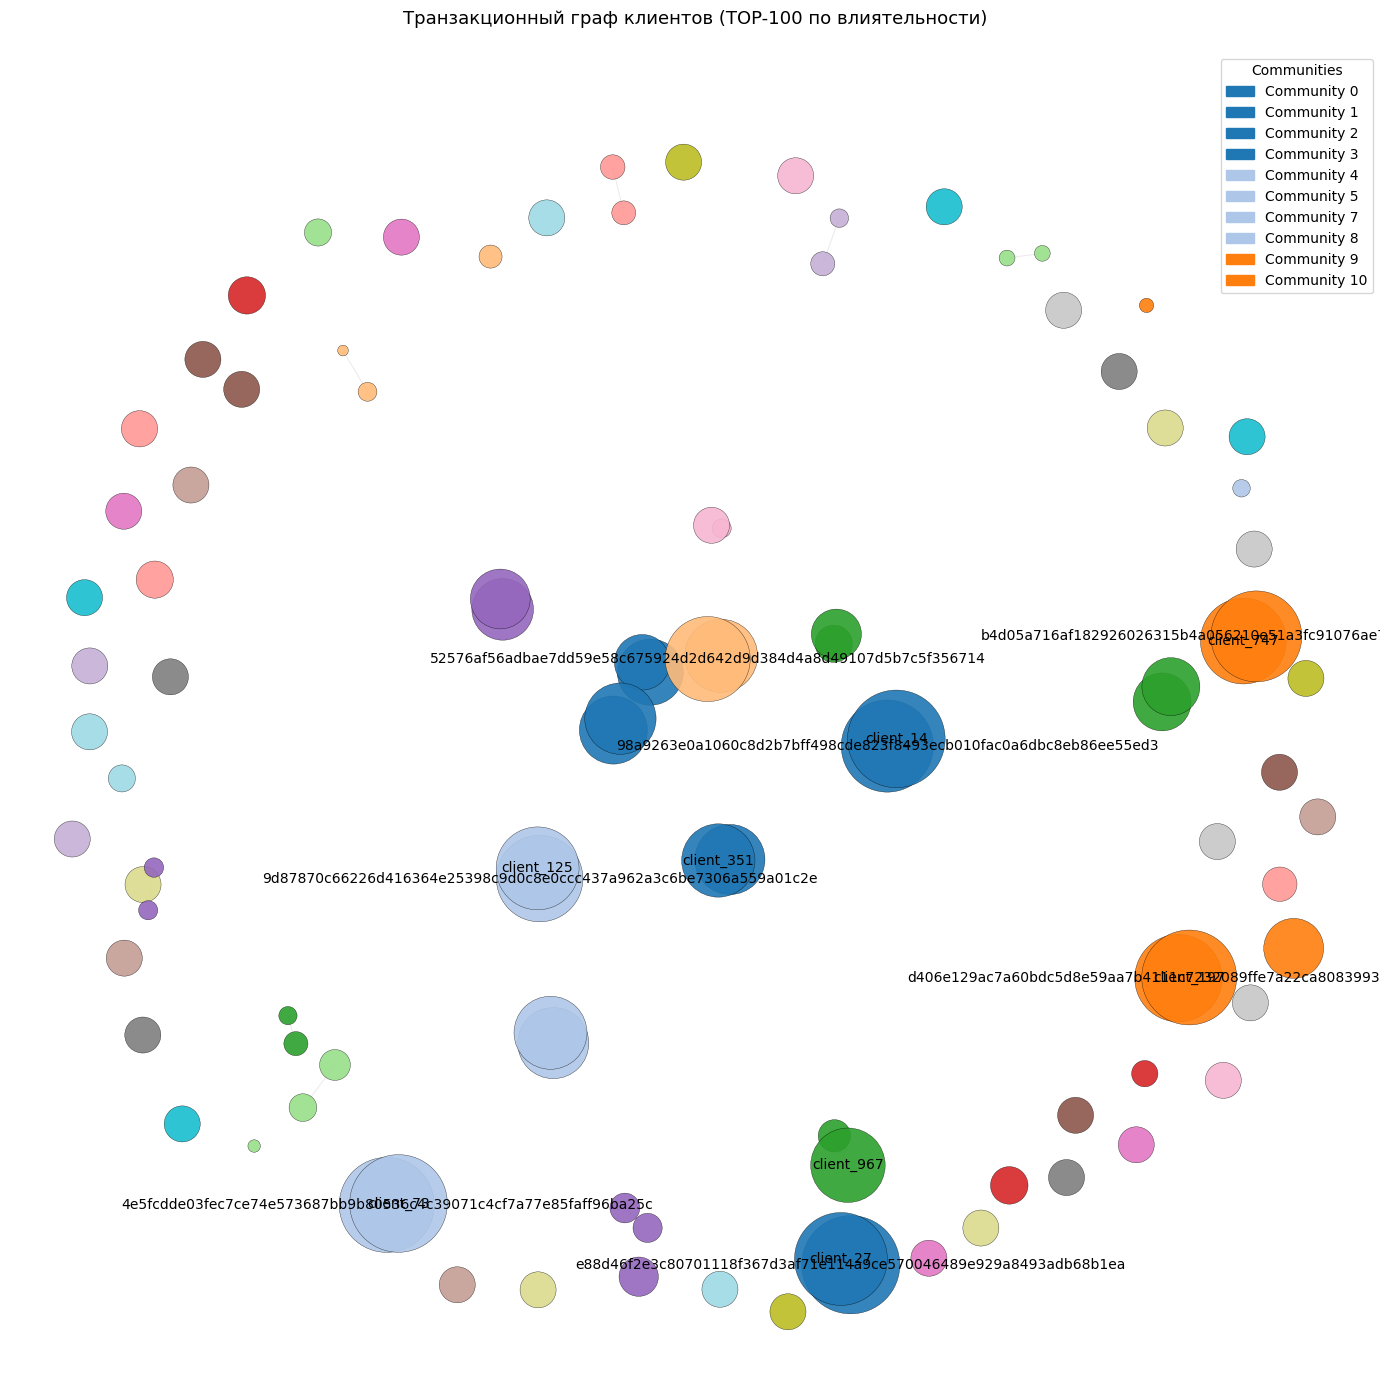

In [14]:
import networkx as nx, matplotlib.pyplot as plt, matplotlib.cm as cm
import matplotlib.patches as mpatches

PATH      = "/home/jovyan/work/reports/client_graph.graphml"
TOP_N     = 100          # сколько узлов показать крупно
LABEL_N   = 15           # сколько подписать
MIN_SIZE  = 60           # px
MAX_SIZE  = 5000         # px
EDGE_ALPHA = 0.08        # «прозрачность» рёбер

# ---------- читаем и нормализуем как в предыдущем скрипте --------------------
G = nx.read_graphml(PATH)
id2name = {"d0":"community_id","d1":"influence_score","d2":"community_size","d3":"w_degree"}
for n,a in G.nodes(data=True):
    clean = {k.split("}")[-1]:v for k,v in a.items()}
    for old,new in id2name.items():
        if old in clean and new not in clean:
            clean[new]=clean.pop(old)
    G.nodes[n].clear(); G.nodes[n].update(clean)
# если вдруг нет community_id / influence_score – досчитаем
if any("community_id"    not in d for d in G.nodes.values()):
    from networkx.algorithms.community import greedy_modularity_communities
    comms = greedy_modularity_communities(G, weight="weight")
    nx.set_node_attributes(G, {v:i for i,c in enumerate(comms) for v in c}, "community_id")
if any("influence_score" not in d for d in G.nodes.values()):
    nx.set_node_attributes(G, nx.pagerank(G, weight="weight"), "influence_score")

# ---------- режем до топ-N по influence --------------------------------------
top = sorted(G.nodes(data=True),
             key=lambda x: float(x[1]["influence_score"]),
             reverse=True)[:TOP_N]
H   = G.subgraph([n for n,_ in top]).copy()

# ---------- layout -----------------------------------------------------------
pos = nx.spring_layout(H, k=0.35, seed=42, weight="weight")

# ---------- цвета и размеры --------------------------------------------------
com_attr  = nx.get_node_attributes(H, "community_id")
uniq_coms = sorted(set(com_attr.values()))
cmap      = cm.get_cmap("tab20")
colors    = [cmap(uniq_coms.index(com_attr[n]) / max(len(uniq_coms)-1,1)) for n in H]

inf   = nx.get_node_attributes(H, "influence_score")
mx, mn = max(inf.values()), min(inf.values())
sizes = [MIN_SIZE + (inf[n]-mn)/(mx-mn)*(MAX_SIZE-MIN_SIZE) for n in H]

# ---------- рисунок ----------------------------------------------------------
plt.figure(figsize=(14,14))
nx.draw_networkx_edges(H, pos, alpha=EDGE_ALPHA, width=0.8)
nx.draw_networkx_nodes(H, pos, node_color=colors, node_size=sizes,
                       edgecolors="black", linewidths=0.25, alpha=0.9)

# подпишем самые влиятельные
labels = {n:n for n,_ in top[:LABEL_N]}
nx.draw_networkx_labels(H, pos, labels, font_size=10)

# компактная легенда по сообществам (макс 10 отсеков, иначе каша)
patches = [mpatches.Patch(color=cmap(uniq_coms.index(c)/max(len(uniq_coms)-1,1)),
                          label=f"Community {c}") for c in uniq_coms[:10]]
plt.legend(handles=patches, frameon=True, title="Communities", loc="upper right")

plt.title(f"Транзакционный граф клиентов (TOP-{TOP_N} по влиятельности)",
          pad=20, fontsize=13)
plt.axis("off"); plt.tight_layout(); plt.show()


In [15]:
# 1. мета-граф
meta = nx.Graph()
for (u,v,d) in G.edges(data=True):
    cu, cv = G.nodes[u]["community_id"], G.nodes[v]["community_id"]
    if cu == cv: continue
    w = d.get("weight",1.0)
    meta.add_edge(cu, cv, weight=meta.get_edge_data(cu,cv,{"weight":0})["weight"]+w)

# 2. координаты центров сообществ
center = nx.spring_layout(meta, k=1.2, seed=42, weight="weight")

# 3. детальный layout внутри каждого community
pos = {}
for c in center:
    members = [n for n,d in G.nodes(data=True) if d["community_id"]==c]
    sub     = G.subgraph(members)
    local   = nx.spring_layout(sub, k=0.3, seed=7, weight="weight")
    # сдвигаем к своему «центру»
    for n,p in local.items():
        pos[n] = p*0.6 + center[c]     # 0.6 — масштаб внутри коммьюнити

# дальше рисуем G с pos --- цвета = community_id, размеры = influence_score


/tmp/ipykernel_59880/3259164102.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab20", len(communities))


Граф сохранён в: /home/jovyan/work/reports/client_graph.png


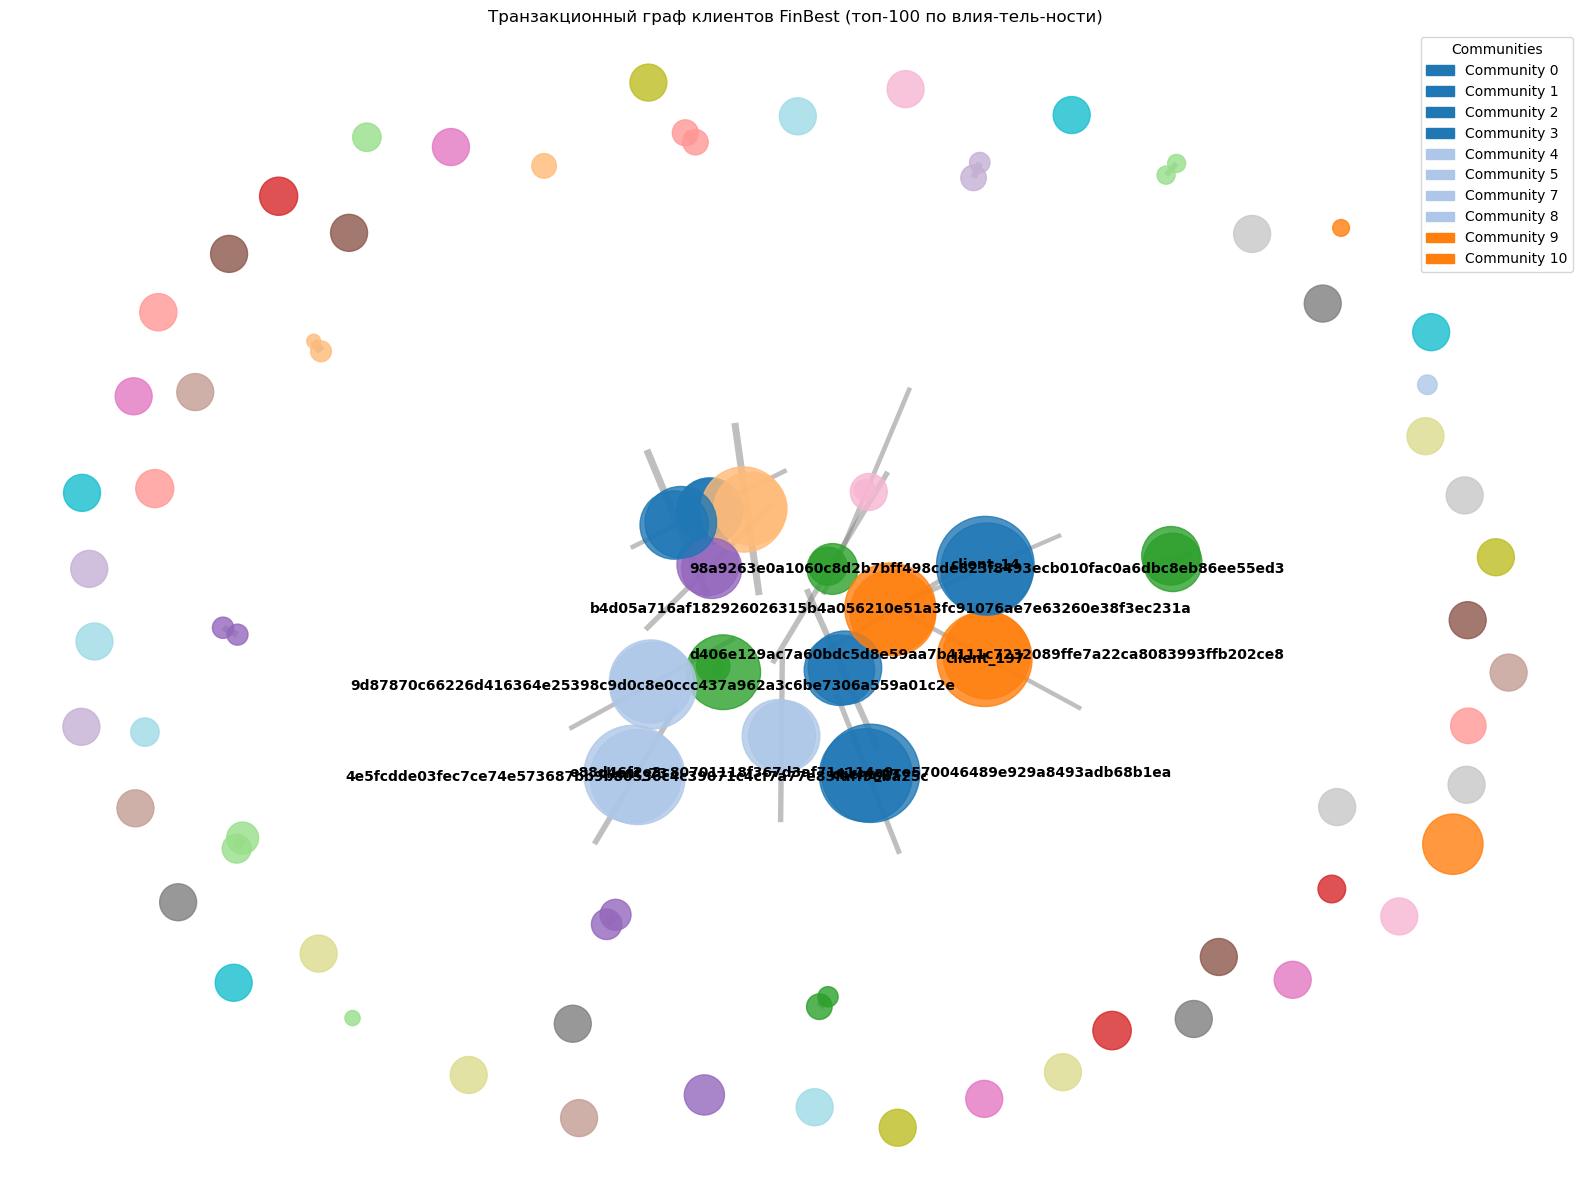

In [16]:
# -*- coding: utf-8 -*-
"""
client_graph_plot.py — «транзакционный» граф в стилистике примера
"""

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from networkx.algorithms.community import greedy_modularity_communities

GRAPH_PATH   = "/home/jovyan/work/reports/client_graph.graphml"
OUT_PNG      = "/home/jovyan/work/reports/client_graph.png"
TOP_N        = 100      # сколько узлов оставить
LABEL_N      = 10       # сколько подписать
EDGE_ALPHA   = 0.5      # прозрачность рёбер
NODE_MIN     = 100      # px
NODE_MAX     = 5000     # px

# --------------------------------------------------------------------------- #
# 1) читаем граф и «человечим» имена атрибутов
# --------------------------------------------------------------------------- #
G = nx.read_graphml(GRAPH_PATH)

id2name = {"d0": "community", "d1": "influence",
           "d2": "community_size", "d3": "w_degree"}

for n, attrs in G.nodes(data=True):
    clean = {k.split("}")[-1]: v for k, v in attrs.items()}  # убираем namespace
    for raw, nice in id2name.items():
        if raw in clean and nice not in clean:
            clean[nice] = clean.pop(raw)
    G.nodes[n].clear()
    G.nodes[n].update(clean)

# --------------------------------------------------------------------------- #
# 2) если вдруг нет community / influence  →  вычислим
# --------------------------------------------------------------------------- #
if any("community" not in d for d in G.nodes.values()):
    comms = greedy_modularity_communities(G, weight="weight")
    nx.set_node_attributes(G,
        {v: i for i, c in enumerate(comms) for v in c}, "community")

if any("influence" not in d for d in G.nodes.values()):
    nx.set_node_attributes(G, nx.pagerank(G, weight="weight"), "influence")

# приводим типы
for d in G.nodes.values():
    d["community"] = int(float(d["community"]))
    d["influence"] = float(d["influence"])

# --------------------------------------------------------------------------- #
# 3) оставляем TOP-N по влиятельности (чтобы не было «синего шара»)
# --------------------------------------------------------------------------- #
top_nodes = sorted(G.nodes,
                   key=lambda n: G.nodes[n]["influence"],
                   reverse=True)[:TOP_N]
G = G.subgraph(top_nodes).copy()

# --------------------------------------------------------------------------- #
# 4) вычисляем layout (force-directed)
# --------------------------------------------------------------------------- #
pos = nx.spring_layout(G, k=0.15, iterations=50, seed=42, weight="weight")

# --------------------------------------------------------------------------- #
# 5) цвета / размеры
# --------------------------------------------------------------------------- #
communities = sorted(set(nx.get_node_attributes(G, "community").values()))
cmap = cm.get_cmap("tab20", len(communities))
comm_color = {c: cmap(i) for i, c in enumerate(communities)}

node_sizes = [
    NODE_MIN + (G.nodes[n]["influence"] - min(nx.get_node_attributes(G, "influence").values()))
    / (max(nx.get_node_attributes(G, "influence").values())
       - min(nx.get_node_attributes(G, "influence").values()) + 1e-9)
    * (NODE_MAX - NODE_MIN)
    for n in G
]
node_colors = [comm_color[G.nodes[n]["community"]] for n in G]

# --------------------------------------------------------------------------- #
# 6) сам рисунок
# --------------------------------------------------------------------------- #
plt.figure(figsize=(16, 12))

# узлы
nx.draw_networkx_nodes(G, pos,
                       node_size=node_sizes,
                       node_color=node_colors,
                       alpha=0.8)

# рёбра
edge_weights = [G[u][v].get("weight", 1.0) for u, v in G.edges()]
nx.draw_networkx_edges(G, pos,
                       width=[w * 0.5 for w in edge_weights],
                       alpha=EDGE_ALPHA,
                       edge_color="grey")

# подписи (TOP-LABEL_N)
top_labels = sorted(G.nodes,
                    key=lambda n: G.nodes[n]["influence"],
                    reverse=True)[:LABEL_N]
nx.draw_networkx_labels(G, pos,
                        labels={n: n for n in top_labels},
                        font_size=10, font_weight="bold")

# легенда
legend_patches = [
    mpatches.Patch(color=comm_color[c], label=f"Community {c}")
    for c in communities[:10]                 # >10 сообществ — каша; показываем первые
]
plt.legend(handles=legend_patches, title="Communities",
           loc="upper right", frameon=True)

plt.title(f"Транзакционный граф клиентов FinBest (топ-{TOP_N} по влия­тель­ности)")
plt.axis("off")
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=300, bbox_inches="tight")
print(f"Граф сохранён в: {OUT_PNG}")
